In [394]:
# Import necessary packages, set device

from itertools import product
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
import torch.nn.init as winit
import torch.nn as nn
import matplotlib.animation as animation
#import matplotlib.pyplot as plt
import pylab as plt
import torch
import torch.nn.functional as Func
import pandas as pd
import scipy.io
import datetime
import numpy as np
import os
import gc

# get the directory of the notebook
p = os.path.dirname("BF.ipynb")
dir = os.path.abspath(p)

# get the directory of the script... uncomment this if you want to use the script as a standalone file
'''
dir = os.path.dirname(os.path.abspath(__file__))
'''

# Change working directory to the script/notebooks's directory
os.chdir(dir)
print("Changed working directory to:", os.getcwd())

# detect GPU
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.backends.cuda.is_available()
    else "cpu"
)

Changed working directory to: /Users/robertdoerner/Documents/Grad/ECE 228 ML for Physical Applications/Project


In [376]:
# Read in raw data, enter basic problem paramters

# hyd_pos is hydrophone (x,y) position matrix with shape (21,2)
hyd_pos_y = torch.tensor([
    94.125,
    99.755,
    105.38,
    111.00,
    116.62,
    122.25,
    127.88,
    139.12,
    144.74,
    150.38,
    155.99,
    161.62,
    167.26,
    172.88,
    178.49,
    184.12,
    189.76,
    195.38,
    200.99,
    206.62,
    212.25
])

hyd_pos_x = torch.zeros_like(hyd_pos_y)
hyd_pos = torch.stack((hyd_pos_x, -hyd_pos_y), dim=1)

# Load ground truth data from file
try:
    s5_ranges  =  pd.read_csv('SproulToVLA.S5.txt', sep=r"\s+") # shape = (77,4); rows - data for each minute
except:
    print("SproulToVLA.S5.txt not found. load S5 ranges.")
try:
    s59_ranges = pd.read_csv('SproulToVLA.S59.txt', sep=r"\s+") # shape = (77,4); rows - data for each minute
except:
    print("SproulToVLA.S59.txt not found. Continuing without S59 ranges.")

# Load raw time series data from file
try:
    mat    = scipy.io.loadmat("s5.mat")
    s5     = torch.from_numpy(mat['s5']) # s5 is a 2D array : s5.shape = (6750000, 21) , len(s5) = 6750000
except FileNotFoundError:
    print("s5.mat not found. load S5.")

try:
    mat = scipy.io.loadmat("s59.mat")
    s59 = torch.from_numpy(mat['s59']) # s59 is a 2D array : s59.shape = (6750000, 21) , len(s59) = 6750000
except FileNotFoundError:
    print("s59.mat not found. Continuing without s59 data.")

# Sampling frequency and start date
SR = 1500 # sampling frequency : constant -> Letter
S5_START_DT = datetime.datetime(1996, 5, 10, hour=23, minute=15, second=0)

# Make the shape information as variables
S5_TIMESTEPS, S5_SENSORS = s5.shape      # N_TIMESTEPS = 6750000, N_SENSORS = 21

#The shallow source was towed at approximately 9m, the deep source at approximately 54m
deep_source_depth = 54 # source depth in m
shallow_source_depth = 9  # source depth in m

# Define the source tonals and bandwidth for filtering later
shallow_source_tonals = torch.tensor([109, 127, 145, 163, 198, 232, 280, 335, 385])
deep_source_tonals = torch.tensor([130,148,166,201,235,283,338,388]) # full set: [49,64,79,94,112,130,148,166,201,235,283,338,388]
bw = 1.5  # bandwidth in Hz

SproulToVLA.S59.txt not found. Continuing without S59 ranges.
s59.mat not found. Continuing without s59 data.


Specify problem to be solved and limits of computation

In [377]:
# specify problem data
DATA = s5

# speed of sound in m/s
C = float(1490)

# specify source to be used
target_tonals = deep_source_tonals
target_depth = deep_source_depth

# specify the time step size
seconds_per_frame = 1

# specify resolution and max range
grid_spacing = 30                       # grid spacing in m
max_range = 8000                        # max range in m
max_depth = 2000                        # max depth in m
bottom_dep = 217                        # bottom depth in m

In [378]:
# Set up problem geometry and perform pre-processing to support beamforming

# Interpolate target ranges to each data frame
frame_length = int(SR * seconds_per_frame)                                  # number of samples per frame
range_per_minute = torch.tensor(s5_ranges["Range(km)"].values) * 1000        # [m]

# Time stamps of original range values (in samples)
t_range = torch.arange(len(range_per_minute)) * 60 * SR                     # sample positions at 0, 60s, 120s, ...

# Frame center times (in samples)
n_frames = S5_TIMESTEPS // frame_length
t_frames = torch.arange(n_frames) * frame_length + frame_length // 2

# Interpolate to frame centers
targ_xpos = torch.from_numpy(np.interp(t_frames.numpy(), t_range.numpy(), range_per_minute.numpy()))
targ_ypos = torch.tensor(-target_depth*np.ones_like(targ_xpos))
targ_pos = torch.stack((targ_xpos, targ_ypos), dim=1)                       # source position in m.

# generate grid
x_grid_coords = torch.arange(-10, max_range, grid_spacing)
y_grid_coords = torch.arange(-max_depth, max_depth-bottom_dep, grid_spacing)
gridpoints = torch.tensor(list(product(x_grid_coords, y_grid_coords)))

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(x_grid_coords, y_grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# Reshape s5 to have dimensions (step, samples, hydrophones)
DATA = DATA[:frame_length * n_frames]  # Trim
DATA = DATA.reshape(n_frames, frame_length, S5_SENSORS).permute(0, 2, 1)  # (step, hydrophone, samples)

# create vector representiang the frequencies of the FFT bins
freqs = torch.fft.fftfreq(DATA.shape[2], 1 / SR)

# convert data to frequency domain
raw_f_data = torch.fft.fft(DATA, dim=2)

# retract the tensor so that the only remaining FFT bins are the ones associated with the frequencys we care about... saves memory as well
mask = torch.zeros_like(freqs, dtype=torch.bool)
for f in target_tonals:
    mask |= (torch.abs(freqs - f) <= bw/2)
masked_freqs = freqs[mask]
masked_f_data = raw_f_data[:,:, mask]

print("data matrix shape is:", DATA.shape)
print("raw frequency data shape is:", raw_f_data.shape)
print("selected frequency data shape is:", masked_f_data.shape)

# move data to device
masked_f_data = masked_f_data.to(dtype = torch.cfloat, device=device)
masked_freqs = masked_freqs.to(dtype = torch.cfloat, device=device)
gridpoints = gridpoints.to(device)
hyd_pos = hyd_pos.to(device)

# Beamforming Function definition
def NBbeamformMPS(hyd_pos, gridpoints, waveform_spectra, freqs, medium_velocity):
    """
    Beamform the given waveforms at the hydrophone positions
    for the given gridpoints.
    
    Args:
        hyd_pos (torch.Tensor): Hydrophone positions (N_hyd, 2).
        gridpoints (torch.Tensor): Grid points (N_grid, 2).
        waveform_spectra (torch.Tensor): Waveform spectra (N_hyd, N_freq). must be cfloat for MPS
        freqs (torch.Tensor): Frequencies (N_freq). must be cfloat for MPS
        medium_velocity (float): Velocity of the medium.
        
    Returns:
        torch.Tensor: Beampowers for each grid point (N_grid).
    """

    omega = 2 * torch.pi * freqs

    distances_to_all_gridpoints = torch.linalg.norm(
        gridpoints[:, None, :] - hyd_pos[None, :, :], axis=2
    )
    traveltimes = distances_to_all_gridpoints / medium_velocity
    del distances_to_all_gridpoints # free memory
    del medium_velocity # free memory
    del hyd_pos # free memory
    del gridpoints # free memory
    del freqs # free memory

    # Green's functions for each hydrophone and grid point
    greens_functions = torch.exp(-1j * omega[None, None, :] * traveltimes[:, :, None])
    del traveltimes # free memory

    # cross-spectral density matrix of Green's functions
    S = greens_functions[:, :, None, :] * greens_functions.conj()[:, None, :, :]
    del greens_functions # free memory
    
    # cross-spectral density matrix of recordings
    K = waveform_spectra[:, None, :] * waveform_spectra.conj()[None, :, :]
    del waveform_spectra # free memory

    # exclude auto-correlations
    diag_idxs = torch.arange(K.shape[0])
    zero_spectra = torch.zeros(omega.shape, dtype=torch.cfloat, device=omega.device)
    K[diag_idxs, diag_idxs, :] = zero_spectra
    del omega # free memory
    del zero_spectra # free memory
    del diag_idxs # free memory

    # Compute cross-correlation beampower per frequency bin
    beampowers = torch.einsum("xkjw, kjw -> xw", S, K)

    return beampowers

# free memory
del mat, s5, DATA, raw_f_data, freqs
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

data matrix shape is: torch.Size([4500, 21, 1500])
raw frequency data shape is: torch.Size([4500, 21, 1500])
selected frequency data shape is: torch.Size([4500, 21, 8])


In [379]:
# Beamform full data set

init = 0                                                                                                # initial frame index

nbp_tensor = torch.empty((n_frames, len(x_grid_coords), len(y_grid_coords), len(masked_freqs)), dtype=torch.float32)    # shape = (n_frames, x_grid_coords, y_grid_coords, n_freqs)

# perform framewise beamforming
for i in tqdm(range(init,n_frames), desc="Beamforming", unit="frame", ncols=200):
    
    gc.collect()                                                                                        # collect garbage
    torch.mps.empty_cache()                                                                             # free memory before each iteration

    nbp = NBbeamformMPS(hyd_pos, gridpoints, masked_f_data[i,:,:], masked_freqs, C)                     # Narrowband Power Spectrum (NBP) beamforming
    nbp = nbp.reshape(len(x_grid_coords), len(y_grid_coords), -1)                                       # reshape to (x, y, freq)
    nbp_tensor[i,:,:,:] = torch.abs(nbp).cpu()                                                          # take, modulus (dont have space to process complex value), move to CPU and store in tensor

# save to disk
torch.save(nbp_tensor, f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# calculate broadband beampower by summing over frequencies
bbp_tensor = nbp_tensor.sum(dim=3).real                                                                 # shape = (n_frames, x_grid_coords, y_grid_coords)

# save to disk
torch.save(bbp_tensor, f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# free memory
del nbp
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Beamforming: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [34:21<00:00,  2.18frame/s]


In [496]:
# Perform Pre-processing for ML algorithms, load beamformed data from file if necessary, define helper functions

front_exclude = 500
back_exclude = 0

try:
    bbp_tensor
    print("using new broadband_beampower_tensor")
except NameError:   
    bbp_tensor = torch.load(f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old broadband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File Broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

try:
    nbp_tensor
    print("using new narrowband_beampower_tensor")
except NameError:   
    nbp_tensor = torch.load(f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old narrowband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

N, X, Y, F = nbp_tensor.shape

try:
    del mask                                                # prevent inadvertent masking due to using the same variable name
except NameError:
    pass                                                    # Variable does not exist, so do nothing

# Create mask that functions for both tensors
# Check if target tonals match the deep source tonals. exclude frames when FM was transmitted, and at the very nearest ranges when sound transmitted to the array via direct path propagation
if torch.equal(target_tonals, deep_source_tonals):
    exclude_frames = set(range(0, front_exclude))                     # First 500 (potentially includes FM chirps)
    exclude_frames.update(range(N - back_exclude, N))                # Last 100 (potentially includes FM chirps)
    exclude_frames.update(range(3493, 3571))                # DP frames (potentially includes FM chirps also)

    mask = torch.ones(N, dtype=torch.bool)
    mask[list(exclude_frames)] = False  # set excluded frames to False
else: mask = torch.ones(bbp_tensor.shape[0], dtype=torch.bool)  # No exclusion mask

# Normalize range and data for regression stability
range_mean = targ_xpos.mean()
range_std = targ_xpos.std()
range_norm = (targ_xpos - range_mean) / range_std
bbeam_norm = (bbp_tensor - bbp_tensor.mean()) / bbp_tensor.std()
nbeam_norm = (nbp_tensor - nbp_tensor.mean()) / nbp_tensor.std()

# move data to CPU for plotting
# nbp_tensor and bbp_tensor are already on CPU due to size constraints
hyd_pos = hyd_pos.cpu()
targ_pos = targ_pos.cpu() 
gridpoints = gridpoints.cpu()

# define custom function to pad data for DataLoader. This is to support using MPS backend which has not implmented adaptive pooling :(
def pad_to_multiple(x, multiple=4, mode='constant', value=0):
    """
    Pads the last two spatial dimensions (H, W) of a tensor to make them divisible by `multiple`.

    Supports 4D (B, C, H, W) and 5D (B, C, T, H, W) inputs.

    Args:
        x (Tensor): Input tensor.
        multiple (int): Target multiple for height and width.
        mode (str): Padding mode (e.g., 'constant', 'reflect', 'replicate').
        value (float): Padding value if mode='constant'.

    Returns:
        x_padded (Tensor): Padded tensor.
        padding (tuple): Padding values used.
    """
    if x.ndim not in (4, 5):
        raise ValueError(f"Expected 4D or 5D tensor, got {x.ndim}D")

    *leading_dims, h, w = x.shape

    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple

    if x.ndim == 4:
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        x_padded = Func.pad(x, padding, mode='reflect')  # or 'constant', 'replicate'   
    else:  # 5D
        # Padding format for F.pad: (pad_w_left, pad_w_right, pad_h_left, pad_h_right)
        # We pad only height and width (last two dims)
        padding = (0, pad_w, 0, pad_h, 0, 0)  # No padding for T (time)
        x_padded = Func.pad(x, padding, mode="constant", value=0)

    return x_padded, padding

# Define a function to initialize weights of a model
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Conv3d)):
        winit.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            winit.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        winit.xavier_uniform_(m.weight)
        if m.bias is not None:
            winit.zeros_(m.bias)


using new broadband_beampower_tensor
using new narrowband_beampower_tensor


2D CNN: X, Y

In [503]:
# Hyper parameters
epochs = 500
learning_rate = 1e-3
lr_sched_factor = 0.1
lr_sched_patience = 25
dropout = 0.2
err_worsening_tol = 5               # x times worse allowed, otherwise the model reverts to best state
early_stop_patience = 100            # stop if no improvement after x epochs

# convolutional layer parameters
kernel_sizes = (5, 3)               # kernel sizes for convolutional layers
stride=2                            # stride for convolutional layers
dilation=2                          # downsampling for first convolutional layer

# fully connected layer parameters
hidden_dim = 128
num_fc_layers = 20
residual_every = 24

In [504]:
# Set up Broadband CNN

class BBBeamformRangeDataset(Dataset):
    def __init__(self, X, y, mask=None):
        if mask is not None:
            self.indices = mask.nonzero(as_tuple=True)[0]
        else:
            self.indices = torch.arange(X.shape[0])
        
        self.X = X[self.indices].unsqueeze(1).float()  # [N, 1, H, W]
        self.y = y[self.indices].unsqueeze(1).float()  # [N, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class BeamCNN(nn.Module):
    def __init__(self, kernel_sizes, stride, dilation, hidden_dim, num_fc_layers, residual_every, dropout, H, W, activation=nn.ReLU()):
        super().__init__()
        k1, k2 = kernel_sizes

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=k1, stride=stride, dilation=dilation), activation(),
            nn.Conv2d(16, 32, kernel_size=k2, stride=2), activation(),
            nn.AvgPool2d(kernel_size=4, stride=4)
            #nn.AdaptiveAvgPool2d((H //4, W //4))  # incompatable with MPS backend
        )

        self.flattened_dim = self._get_flatten_size(H, W)

        # Construct FC layers dynamically
        fc_layers = [nn.Flatten()]
        fc_layers.append(nn.Linear(self.flattened_dim, hidden_dim))
        fc_layers.append(activation())
        fc_layers.append(nn.Dropout(dropout))

        # Add residual blocks or standard layers
        for i in range(num_fc_layers - 1):
            if i % residual_every == 0:
                fc_layers.append(ResidualBlock(hidden_dim, activation, dropout))
            else:
                fc_layers.append(nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    activation(),
                    nn.Dropout(dropout)
                ))

        fc_layers.append(nn.Linear(hidden_dim, 1))
        self.fc = nn.Sequential(*fc_layers)

    def _get_flatten_size(self, H, W):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, H, W)
            dummy_input, _ = pad_to_multiple(dummy_input, multiple=4) # pad to multiple of 4 for compatibility with unadaptive pool
            out = self.cnn(dummy_input)
            return out.view(1, -1).shape[1]

    def forward(self, x):
        x = self.cnn(x)
        return self.fc(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim, activation, dropout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            activation(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            activation(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return x + self.block(x)



# Get valid indices (non-excluded)
valid_indices = mask.nonzero(as_tuple=True)[0]

# Randomly split into train and val (e.g., 90/10)
train_idx, val_idx = train_test_split(valid_indices, test_size=0.1, random_state=42)

# Create full-length masks
train_mask = torch.zeros(N, dtype=torch.bool)
val_mask = torch.zeros(N, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True

# Create datasets and dataloaders
train_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=train_mask)
val_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=val_mask)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Epochs:  42%|██████████████████████████████████████████▏                                                          | 209/500 [11:26<15:55,  3.28s/epoch, MAE=87.8, best_val=0.293, train=1.63, val=0.354]

Early stopping triggered.


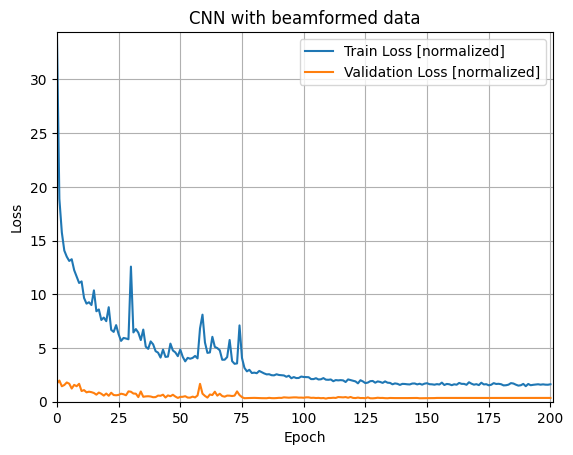

Final validation error - MSE: 0.29 sigma^2 MAE: 83.76 meters


In [505]:
# Train and Validate Broadband CNN

model = BeamCNN(kernel_sizes=kernel_sizes, stride=stride, dilation=dilation, hidden_dim=hidden_dim, num_fc_layers=num_fc_layers, 
                residual_every=residual_every, dropout=dropout, H=Y, W=X, activation=nn.GELU)

model.apply(init_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_sched_factor, patience=lr_sched_patience)
loss_fn = nn.MSELoss()
model = model.to(device)

plt.ion()
fig1, ax = plt.subplots()
line1, = ax.plot([], [], label="Train Loss [normalized]")
line2, = ax.plot([], [], label="Validation Loss [normalized]")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("CNN with beamformed data")
ax.grid(True)
ax.legend()

best_val_loss = float('inf')
best_model_state = None
train_losses = []
val_losses = []
mae_losses = []

loop = tqdm(range(epochs), desc="Epochs", unit="epoch", ncols=200)
for epoch in loop:

    # training
    model.train()
    total_train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb, _ = pad_to_multiple(xb, multiple=4)  # padding applied
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_losses.append(total_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb, _ = pad_to_multiple(xb, multiple=4)  # padding applied
            pred = model(xb)
            loss = loss_fn(pred, yb)
            total_val_loss += loss.item()

            # Unnormalize to real-world units (meters)
            pred_real = pred * range_std + range_mean
            yb_real = yb * range_std + range_mean
            total_mae_loss = torch.mean(torch.abs(pred_real - yb_real)).item()
    val_losses.append(total_val_loss)
    mae_losses.append(total_mae_loss)

    # Step scheduler
    scheduler.step(total_val_loss)

    # Update tqdm bar
    loop.set_postfix(train=total_train_loss, val=total_val_loss, MAE=total_mae_loss, best_val= min(val_losses))

    # record best model
    if total_val_loss < best_val_loss * 0.999:
        best_val_loss = min(total_val_loss, best_val_loss)
        best_model_state = model.state_dict()  # Save best parameters
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    # If validation worsens too much, revert
    if total_val_loss > err_worsening_tol * best_val_loss:
        print(f"Reverting to best model (val_loss {total_val_loss:.4f} > {err_worsening_tol:.1f}× best {best_val_loss:.4f})")
        model.load_state_dict(best_model_state)  # Restore best parameters

    # Update plot every 10 epochs
    if epoch  % 10 == 0:
        line1.set_data(range(len(train_losses)), train_losses)
        line2.set_data(range(len(val_losses)), val_losses)
        ax.set_xlim(0, len(train_losses))
        ax.set_ylim(0, max(max(train_losses), max(val_losses)) + 0.1)
        fig1.canvas.draw()
        fig1.canvas.flush_events()

    if epochs_no_improve >= early_stop_patience:
        print("Early stopping triggered.")
        break

plt.ioff()
plt.show()

print(f"Final validation error - MSE: {min(val_losses):.2f} sigma^2 MAE: {mae_losses[val_losses.index(min(val_losses))]:.2f} meters")

model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "broadband_beamforming_cnn_model.pt")

bb_val_loss = min(val_losses)

# Free memory
del optimizer, loss_fn, train_loader, val_loader, train_dataset, val_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

3D CNN: X, Y, Frequency

In [506]:
# Hyper parameters
epochs = 100
learning_rate = 1e-3
lr_sched_factor = 0.1
lr_sched_patience = 10
dropout = 0.2
err_worsening_tol = 5                       # x times worse allowed, otherwise the model reverts to best state
early_stop_patience = 25                    # stop if no improvement after x epochs

# Convolutional layer parameters
kernel_sizes =  [(4, 5, 5),     (2, 3, 3)]  # 2 kernels for 3D conv (freq, height, width)
strides =       [(1, 2, 2),     (1, 2, 2)]  # stride for convolutional layers
dilations =     [(1, 2, 2),     (1, 2, 2)]  # downsampling for first convolutional layer

# Fully connected layer parameters
hidden_dim = 256
num_fc_layers = 22
residual_every = 24

In [507]:
# Set up Narrowband CNN

class NBBeamformDataset(torch.utils.data.Dataset):
    def __init__(self, nbeam_norm, range_targets, mask):
        if mask is not None:
            self.X = nbeam_norm[mask]
            self.y = range_targets[mask]
        else:
            self.X = nbeam_norm
            self.y = range_targets

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx].permute(2, 0, 1).unsqueeze(0)  # [1, F, X, Y]
        return x.float(), self.y[idx].float()

class BeamCNN3D(nn.Module):
    def __init__(self, kernel_sizes, strides, dilations, hidden_dim, num_fc_layers, residual_every, dropout, H, W, F, activation=nn.ReLU):
        super().__init__()

        k1, k2 = kernel_sizes  # Each kernel is a (T, H, W) tuple
        stride1, stride2 = strides
        dilation1, dilation2 = dilations
        self.activation = activation()

        self.cnn = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=k1, stride=stride1, dilation=dilation1), self.activation,
            nn.Conv3d(16, 32, kernel_size=k2, stride=stride2, dilation=dilation2), self.activation
        )

        # We'll use avg pooling manually after CNN blocks
        self.pool_kernel = (1, 4, 4)
        self.pool_stride = (1, 4, 4)

        self.flattened_dim = self._get_flatten_size(F, H, W)

        # Construct FC layers dynamically
        fc_layers = [nn.Flatten()]
        fc_layers.append(nn.Linear(self.flattened_dim, hidden_dim))
        fc_layers.append(activation())
        fc_layers.append(nn.Dropout(dropout))

        # Add residual blocks or standard layers
        for i in range(num_fc_layers - 1):
            if i % residual_every == 0:
                fc_layers.append(ResidualBlock(hidden_dim, activation, dropout))
            else:
                fc_layers.append(nn.Sequential(
                    nn.Linear(hidden_dim, hidden_dim),
                    activation(),
                    nn.Dropout(dropout)
                ))

        fc_layers.append(nn.Linear(hidden_dim, 1))
        self.fc = nn.Sequential(*fc_layers)

    def _get_flatten_size(self, F, H, W):
        with torch.no_grad():
            dummy = torch.zeros(1, 1, F, H, W)
            dummy, _ = pad_to_multiple(dummy, multiple=4)
            out = self.cnn(dummy)
            # apply 2D pooling across time slices
            out = self._avgpool_2d_over_time(out)
            return out.reshape(1, -1).shape[1]

    def _avgpool_2d_over_time(self, x):
        # x: [B, C, T, H, W] → (B*T, C, H, W)
        B, C, F, H, W = x.shape
        x = x.permute(0, 2, 1, 3, 4).reshape(B * F, C, H, W)
        x = Func.avg_pool2d(x, kernel_size=self.pool_kernel[1:], stride=self.pool_stride[1:])
        # Back to [B, C, T, H', W']
        x = x.reshape(B, F, C, x.shape[-2], x.shape[-1]).permute(0, 2, 1, 3, 4)
        return x

    def forward(self, x):
        x = self.cnn(x)                        # [B, C, T, H, W]
        x = self._avgpool_2d_over_time(x)     # [B, C, T, H', W']
        return self.fc(x)                     # → regression output

class ResidualBlock(nn.Module):
    def __init__(self, dim, activation, dropout):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            activation(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            activation(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return x + self.block(x)

# Get valid indices (non-excluded)
valid_indices = mask.nonzero(as_tuple=True)[0]

# Randomly split into train and val (e.g., 90/10)
train_idx, val_idx = train_test_split(valid_indices, test_size=0.1, random_state=42)

# Create full-length masks
train_mask = torch.zeros(N, dtype=torch.bool)
val_mask = torch.zeros(N, dtype=torch.bool)

train_mask[train_idx] = True
val_mask[val_idx] = True

# Create datasets and dataloaders
nb_train_dataset = NBBeamformDataset(nbeam_norm, range_norm, mask=train_mask)
nb_val_dataset   = NBBeamformDataset(nbeam_norm, range_norm, mask=val_mask)

nb_train_loader = DataLoader(nb_train_dataset, batch_size=32, shuffle=True)
nb_val_loader   = DataLoader(nb_val_dataset, batch_size=32, shuffle=False)

Epochs:  60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [44:05<29:23, 44.09s/epoch, MAE=92.8, best_val=0.17, train=0.821, val=0.193]

Early stopping triggered.


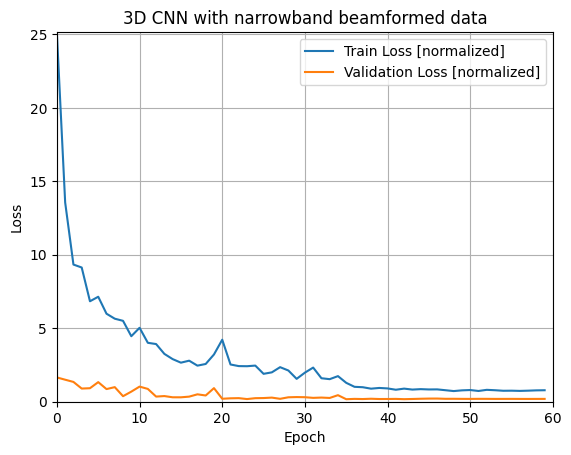

Final validation error - MSE: 0.17 sigma^2 MAE: 96.76 meters


In [508]:
# Train and Validate Narrowband CNN

model2 = BeamCNN3D(kernel_sizes=kernel_sizes, strides=strides, dilations=dilations, hidden_dim=hidden_dim, num_fc_layers=num_fc_layers, 
                   residual_every=residual_every, dropout=dropout, F=F, H=Y, W=X, activation=nn.GELU)

model2.apply(init_weights)
optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=lr_sched_factor, patience=lr_sched_patience)
loss_fn = nn.MSELoss()
model2 = model2.to(device)

best_val_loss = float('inf')
best_model2_state = None
train_losses = []
val_losses = []
mae_losses = []

plt.ion()  # Enable interactive mode
fig2, ax = plt.subplots()
line1, = ax.plot([], [], label="Train Loss [normalized]")
line2, = ax.plot([], [], label="Validation Loss [normalized]")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("3D CNN with narrowband beamformed data")
ax.grid(True)
ax.legend()

loop = tqdm(range(epochs), desc="Epochs", unit="epoch", ncols=200)
for epoch in loop:
    model2.train()
    total_train_loss = 0

    for xb, yb in nb_train_loader:
        xb, yb = xb.to(device), yb.to(device)
        xb, _ = pad_to_multiple(xb, multiple=4)  # optional for compatibility

        pred = model2(xb)
        loss = loss_fn(pred.squeeze(-1), yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    train_losses.append(total_train_loss)

    # Validation
    model2.eval()
    total_val_loss = 0
    with torch.no_grad():
        for xb, yb in nb_val_loader:
            xb, yb = xb.to(device), yb.to(device)
            xb, _ = pad_to_multiple(xb, multiple=4)

            pred = model2(xb)
            loss = loss_fn(pred.squeeze(-1), yb)
            total_val_loss += loss.item()

            # Unnormalize to real-world units (meters)
            pred_real = pred * range_std + range_mean
            yb_real = yb * range_std + range_mean
            total_mae_loss = torch.mean(torch.abs(pred_real - yb_real)).item()
    val_losses.append(total_val_loss)
    mae_losses.append(total_mae_loss)

    # Step scheduler
    scheduler.step(total_val_loss)

    # record best model
    if total_val_loss < best_val_loss * 0.999:
        best_val_loss = min(total_val_loss, best_val_loss)
        best_model2_state = model2.state_dict()  # Save best parameters
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    # If validation worsens too much, revert
    if total_val_loss > err_worsening_tol * best_val_loss:
        print(f"Reverting to best model (val_loss {total_val_loss:.4f} > {err_worsening_tol:.1f}× best {best_val_loss:.4f})")
        model2.load_state_dict(best_model2_state)  # Restore best parameters

    # Update tqdm bar
    loop.set_postfix(train=total_train_loss, val=total_val_loss, MAE=total_mae_loss, best_val= min(val_losses))

    # Update plot every 10 epochs
    if (epoch + 1) % 10 == 0:
        line1.set_data(range(len(train_losses)), train_losses)
        line2.set_data(range(len(val_losses)), val_losses)
        ax.set_xlim(0, len(train_losses))
        ax.set_ylim(0, max(max(train_losses), max(val_losses)) + 0.1)
        fig2.canvas.draw()
        fig2.canvas.flush_events()

    if epochs_no_improve >= early_stop_patience:
        print("Early stopping triggered.")
        break

plt.ioff()
plt.show()

print(f"Final validation error - MSE: {min(val_losses):.2f} sigma^2 MAE: {mae_losses[val_losses.index(min(val_losses))]:.2f} meters")

model2.load_state_dict(best_model2_state)  # Restore best parameters
torch.save(model2.state_dict(), "narrowband_beamforming_cnn_model.pt")

nb_val_loss = min(val_losses)

# Free memory
del optimizer, loss_fn, nb_train_loader, nb_val_loader, nb_train_dataset, nb_val_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Predict and adaptively filter position for the training data set

In [514]:
# Adaptive filter parameters
approx_speed_knts = 5                   # Approximate speed of the source in knots
init_range = 8000                       # initial range in meters
init_uncert = 1.00000000e-04           # initial uncertainty
vel_noise = 1.00000000e-04             # process noise: how much you trust smooth dynamics

# Broadband
bb_pos_noise = 5.74701769e-01             # process noise: how much you trust smooth dynamics
bb_obs_noise = 2.01952099e+03           # observation noise: how much you trust the NN

# Narrowband
nb_pos_noise = 4.63893573e-01             # process noise: how much you trust smooth dynamics
nb_obs_noise = 1.46662065e+03           # observation noise: how much you trust the NN

In [515]:
# Predict ranges on the whole data set with broadband beamforming and adaptively filter

# Load the data set in time-series style batching
ani_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=None)
ani_loader = DataLoader(ani_dataset, batch_size=1, shuffle=False)

knots_to_mps = 0.514444
approx_speed_mps = 5 * knots_to_mps

def fx(x, dt):
    # Constant velocity model
    r = x[0] + x[1] * dt
    dr = x[1]
    return np.array([r, dr])

def hx(x):
    # Observation is range only
    return np.array([x[0]])

points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
bb_ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=seconds_per_frame, points=points)

bb_ukf.x = np.array([init_range, approx_speed_mps])
bb_ukf.P *= init_uncert                         # initial uncertainty
bb_ukf.Q *= np.diag([bb_pos_noise,vel_noise])      # process noise: how much you trust smooth dynamics
bb_ukf.R *= bb_obs_noise                           # observation noise: how much you trust NN predictions

# Predict with Broadband CNN and filter
bb_predicted_ranges = []
bb_filtered_ranges = []

model.eval()
with torch.no_grad():
    for x, _ in tqdm(ani_loader, desc="Predicting and On-line Adaptively Filtering", unit="frame", ncols=200):

        # CNN step
        x = x.to(device)
        pred = model(x).item()
        unnormalized_pred = pred * range_std + range_mean
        bb_predicted_ranges.append(unnormalized_pred)

        # UKF step
        bb_ukf.predict()
        bb_ukf.update(np.array([unnormalized_pred]))
        bb_filtered_ranges.append(bb_ukf.x[0])

# Convert to tensors
bb_predicted_ranges = torch.tensor(bb_predicted_ranges)
bb_filtered_ranges = torch.tensor(bb_filtered_ranges)

#calculate performance of the UKF
mse = torch.mean(((bb_filtered_ranges - range_mean)/range_std - targ_pos[:,0]) ** 2).item()
mae = torch.mean(torch.abs(bb_filtered_ranges - targ_pos[:,0])).item()

print(f"Filtered BB prediction MSE: {mse:.2f} sigma^2")
print(f"Filtered BB prediction MAE: {mae:.2f} m")

def evaluate_ukf(params, cnn_preds, ground_truth, dt, range_mean, range_std):
    init_uncert, pos_noise, vel_noise, obs_noise = params

    # UKF setup
    def fx(x, dt): return np.array([x[0] + x[1] * dt, x[1]])
    def hx(x): return np.array([x[0]])

    points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
    ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=dt, points=points)
    
    ukf.x = np.array([ground_truth[0], 5 * 0.514444])
    ukf.P *= init_uncert
    ukf.Q *= np.diag([pos_noise, vel_noise])
    ukf.R *= obs_noise

    filtered = []
    for pred in cnn_preds:
        ukf.predict()
        ukf.update(np.array([pred]))
        filtered.append(ukf.x[0])

    filtered = np.array(filtered)
    error = np.mean((filtered - ground_truth) ** 2)
    return error

initial_guess = [init_uncert, bb_pos_noise, vel_noise, bb_obs_noise]
bounds = [(1e-4, 1e2),(1e-4, 1e2), (1e-4, 1e2), (1e-2, 1e4)]

res = minimize(
    evaluate_ukf,
    initial_guess,
    args=(bb_predicted_ranges.cpu().numpy(), targ_pos[:, 0].cpu().numpy(), seconds_per_frame, range_mean, range_std),
    bounds=bounds,
    method="L-BFGS-B"
)

print("Optimal UKF parameters (for next time):", res.x)

# Free memory
del x, pred, ani_loader, ani_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Predicting and On-line Adaptively Filtering: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:13<00:00, 338.77frame/s]


Filtered BB prediction MSE: 19805608.77 sigma^2
Filtered BB prediction MAE: 407.85 m
Optimal UKF parameters (for next time): [1.00000000e-04 5.74798677e-01 1.00000000e-04 2.01976209e+03]


In [516]:
# Predict ranges on the whole data set with Narrowband beamforming and adaptively filter

# Load the data set in time-series style batching
nb_ani_dataset = NBBeamformDataset(nbeam_norm, range_norm, mask=None)
nb_ani_loader = DataLoader(nb_ani_dataset, batch_size=1, shuffle=False)

# Set up unscented Kalman Filter
knots_to_mps = 0.514444
approx_speed_mps = 5 * knots_to_mps

def fx(x, dt):
    # Constant velocity model
    r = x[0] + x[1] * dt
    dr = x[1]
    return np.array([r, dr])

def hx(x):
    # Observation is range only
    return np.array([x[0]])

points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
nb_ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=seconds_per_frame, points=points)

nb_ukf.x = np.array([init_range, approx_speed_mps])
nb_ukf.P *= init_uncert                         # initial uncertainty
nb_ukf.Q *= np.diag([nb_pos_noise,vel_noise])      # process noise: how much you trust smooth dynamics
nb_ukf.R *= nb_obs_noise                           # observation noise: how much you trust NN predictions

# Predict with Narrowband CNN and filter
nb_predicted_ranges = []
nb_filtered_ranges = []

model2.eval()
with torch.no_grad():
    for x, _ in tqdm(nb_ani_loader, desc="Predicting and On-line Adaptively Filtering", unit="frame", ncols=200):

        # CNN step
        x = x.to(device)
        pred = model2(x).item()
        unnormalized_pred = pred * range_std + range_mean
        nb_predicted_ranges.append(unnormalized_pred)

        # UKF step
        nb_ukf.predict()
        nb_ukf.update(np.array([unnormalized_pred]))
        nb_filtered_ranges.append(nb_ukf.x[0])

# Convert to tensors
nb_predicted_ranges = torch.tensor(nb_predicted_ranges)
nb_filtered_ranges = torch.tensor(nb_filtered_ranges)

#calculate performance of the UKF
mse = torch.mean(((nb_filtered_ranges - range_mean)/range_std - targ_pos[:,0]) ** 2).item()
mae = torch.mean(torch.abs(nb_filtered_ranges - targ_pos[:,0])).item()

print(f"Filtered NB MSE: {mse:.2f} sigma^2")
print(f"Filtered NB MAE: {mae:.2f} m")

def evaluate_ukf(params, cnn_preds, ground_truth, dt, range_mean, range_std):
    init_uncert, pos_noise, vel_noise, obs_noise = params

    # UKF setup
    def fx(x, dt): return np.array([x[0] + x[1] * dt, x[1]])
    def hx(x): return np.array([x[0]])

    points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
    ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=dt, points=points)
    
    ukf.x = np.array([ground_truth[0], 5 * 0.514444])
    ukf.P *= init_uncert
    ukf.Q *= np.diag([pos_noise, vel_noise])
    ukf.R *= obs_noise

    filtered = []
    for pred in cnn_preds:
        ukf.predict()
        ukf.update(np.array([pred]))
        filtered.append(ukf.x[0])

    filtered = np.array(filtered)
    error = np.mean((filtered - ground_truth) ** 2)
    return error

def evaluate_ukf(params, cnn_preds, ground_truth, dt, range_mean, range_std):
    init_uncert, pos_noise, vel_noise, obs_noise = params

    # UKF setup
    def fx(x, dt): return np.array([x[0] + x[1] * dt, x[1]])
    def hx(x): return np.array([x[0]])

    points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
    ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=dt, points=points)
    
    ukf.x = np.array([ground_truth[0], 5 * 0.514444])
    ukf.P *= init_uncert
    ukf.Q *= np.diag([pos_noise, vel_noise])
    ukf.R *= obs_noise

    filtered = []
    for pred in cnn_preds:
        ukf.predict()
        ukf.update(np.array([pred]))
        filtered.append(ukf.x[0])

    filtered = np.array(filtered)
    error = np.mean((filtered - ground_truth) ** 2)
    return error

initial_guess = [init_uncert, nb_pos_noise, vel_noise, nb_obs_noise]
bounds = [(1e-4, 1e2),(1e-4, 1e2), (1e-4, 1e2), (1e-2, 1e4)]

res = minimize(
    evaluate_ukf,
    initial_guess,
    args=(nb_predicted_ranges.cpu().numpy(), targ_pos[:, 0].cpu().numpy(), seconds_per_frame, range_mean, range_std),
    bounds=bounds,
    method="L-BFGS-B"
)

print("Optimal UKF parameters (for next time):", res.x)

# Free memory
del x, pred, nb_ani_loader, nb_ani_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Predicting and On-line Adaptively Filtering: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:17<00:00, 255.24frame/s]


Filtered NB MSE: 19805412.36 sigma^2
Filtered NB MAE: 306.97 m
Optimal UKF parameters (for next time): [1.00000000e-04 4.46140546e-01 1.00000000e-04 1.47000786e+03]


Results Visualization and Evaluation

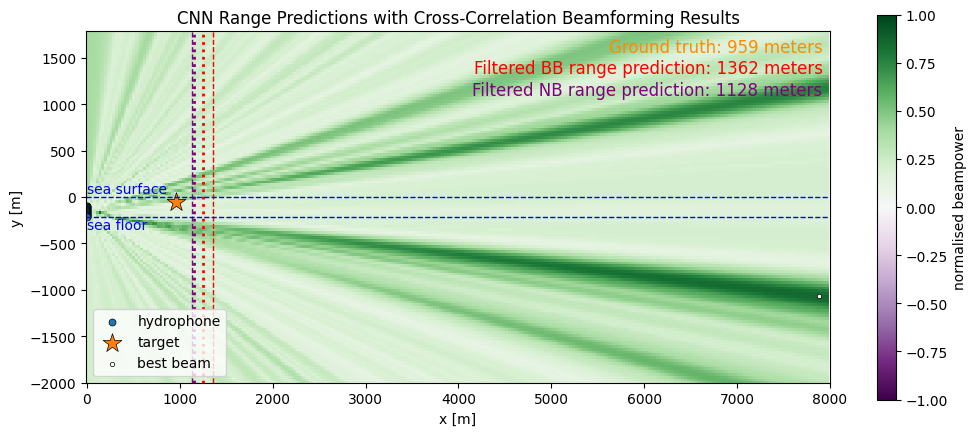

In [528]:
# select a time to plot
plot = 60                                                                          # time to be plotted in minutes (0 - 76)
plot = int(plot * 60 / seconds_per_frame)                                           # convert to frame index

# normalise beampower to max value for visualisation
bbp_vis = bbp_tensor / abs(bbp_tensor).max()

# move data to CPU for plotting
# nbp_tensor and bbp_tensor are already on CPU due to size constraints
hyd_pos = hyd_pos.cpu()
targ_pos = targ_pos.cpu() 
gridpoints = gridpoints.cpu()

fig4, ax = plt.subplots(figsize=(12, 5))

xt, yt = targ_pos[plot,:].T
pcm = ax.pcolormesh(xx, yy, bbp_vis[plot].T, cmap="PRGn", vmin=-1, vmax=1)
ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
ax.scatter(xt, yt, marker="*", s=200, label="target", ec='k', lw=0.5)
ax.scatter(
    *gridpoints[bbp_vis[plot].argmax()],
    marker="o",
    ec="k",
    lw=0.5,
    c="w",
    s=10,
    label="best beam",
)
ax.text(0.99, 0.98, f"Ground truth: {int(targ_pos[plot,0])} meters", transform=ax.transAxes,
                    fontsize=12, color='darkorange', va='top', ha='right')

try:
    ax.axvline(x=bb_predicted_ranges[plot], color='red', linestyle=':', linewidth=2)
    ax.axvline(x=bb_filtered_ranges[plot], color='red', linestyle='--', linewidth=1)
    ax.text(0.99, 0.92, f"Filtered BB range prediction: {int(bb_filtered_ranges[plot])} meters", transform=ax.transAxes,
                    fontsize=12, color='red', va='top', ha='right')
except:
    pass
try:
    ax.axvline(x=nb_predicted_ranges[plot], color='purple', linestyle=':', linewidth=2)
    ax.axvline(x=nb_filtered_ranges[plot], color='purple', linestyle='--', linewidth=1)
    ax.text(0.99, 0.86, f"Filtered NB range prediction: {int(nb_filtered_ranges[plot])} meters", transform=ax.transAxes,
                        fontsize=12, color='purple', va='top', ha='right')
except:
    pass

plt.colorbar(pcm, label="normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=1)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=1)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth-bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title("CNN Range Predictions with Cross-Correlation Beamforming Results")
plt.show()

In [518]:
# Animate the full data set with overlayed range predictions

# normalise beampower to max value for visualisation
bbp_vis = bbp_tensor / abs(bbp_tensor).max()

fig5, ax = plt.subplots(figsize =(12, 5))

pcm = ax.pcolormesh(xx, yy, bbp_vis[0].T, cmap="PRGn", vmin=-1, vmax=1)
hyds = ax.scatter(*hyd_pos.T, marker=".", s=100, label="hydrophone", ec='k', lw=0.5)
targ = ax.scatter(*targ_pos[0], marker="*", s=200, label="target", ec='k', lw=0.5)
best = ax.scatter(*gridpoints[0], marker="o", ec="k", lw=0.5, c="w", s=10, label="best beam")

#plt.colorbar(pcm, ax=ax, label= "normalised beampower")
ax.axhline(y=-bottom_dep, color='blue', linestyle='--', linewidth=1)
ax.text(x=5, y=-bottom_dep-10, s='sea floor', color='blue', va='top', ha='left')
ax.axhline(y=0, color='blue', linestyle='--', linewidth=1)
ax.text(x=5, y=10, s='sea surface', color='blue', va='bottom', ha='left')
ax.set_xlim(-10, max_range)
ax.set_ylim(-max_depth, max_depth - bottom_dep)
ax.set_aspect("equal")
ax.legend(loc=3)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
time_text = ax.text(0.01, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='black', va='top', ha='left')
gt_text = ax.text(0.99, 0.98, "", transform=ax.transAxes,
                    fontsize=12, color='darkorange', va='top', ha='right')

# Add predicted range lines and texts conditionally
pred_handles = []

# Broadband
if 'bb_filtered_ranges' in globals():
    bb_pred_line = ax.axvline(x=0, color='red', linestyle=':', linewidth=2, label="Broadband Predicted Range")
    bb_filt_line = ax.axvline(x=0, color='red', linestyle='--', linewidth=1, label="Broadband Filtered Range")
    bb_filt_text = ax.text(0.99, 0.92, "", transform=ax.transAxes, fontsize=12, color='red', va='top', ha='right')
    pred_handles.append(('BB', bb_pred_line, bb_filt_line, bb_filt_text, bb_filtered_ranges, bb_filtered_ranges))

# Narrowband
if 'nb_filtered_ranges' in globals():
    nb_pred_line = ax.axvline(x=0, color='purple', linestyle=':', linewidth=2, label="Narrowband Predicted Range")
    nb_filt_line = ax.axvline(x=0, color='purple', linestyle='--', linewidth=1, label="Narrowband Filtered Range")
    nb_filt_text = ax.text(0.99, 0.86, "", transform=ax.transAxes, fontsize=12, color='purple', va='top', ha='right')
    pred_handles.append(('NB', nb_pred_line, nb_filt_line, nb_filt_text, nb_predicted_ranges, nb_filtered_ranges))

# Frame update
def update(frame):
    pcm.set_array(bbp_vis[frame].T.ravel())
    targ.set_offsets(targ_pos[frame])
    best.set_offsets(gridpoints[bbp_vis[frame].argmax()])

    for label, pred_line, filt_line, text, preds, filts in pred_handles:
        pred_line.set_xdata([preds[frame]])
        filt_line.set_xdata([filts[frame]])
        text.set_text(f"Filtered {label.upper()} predicted range: {int(filts[frame]):.0f} m")

    # Update timestamp and frame
    current_time = S5_START_DT + datetime.timedelta(seconds=frame * seconds_per_frame)
    time_str = f"Frame {frame:03d} — {current_time.strftime('%Y-%m-%d %H:%M:%S')}"

    # Update the text
    time_text.set_text(time_str)
    gt_text.set_text(f"Ground Truth: {targ_pos[frame, 0].item():.0f} m")

    return pcm, targ, best, time_text, gt_text, pred_handles

ani = animation.FuncAnimation(fig5, update, frames=bbp_vis.shape[0], blit=False)

plt.close(fig5)

# Save to mp4 or display
ani.save(f"beamforming_animation_prediction{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.mp4", fps=30)

# Free memory
del ani, pcm, hyds, targ, best, time_text, gt_text, pred_handles
try:
    del bb_pred_line, bb_filt_text, bb_filt_line
except NameError:
    pass  # Variable does not exist, so do nothing
try:
    del nb_pred_line, nb_filt_text, nb_filt_line
except NameError:
    pass  # Variable does not exist, so do nothing
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()


Now Load and Process the Unseen Data

In [519]:
# specify problem data
DATA = s59

# speed of sound in m/s
C = float(1490)

# specify source to be used
target_tonals = deep_source_tonals
target_depth = deep_source_depth

# specify the time step size
seconds_per_frame = 1

# specify resolution and max range
grid_spacing = 50                       # grid spacing in m
max_range = 8000                        # max range in m
max_depth = 2000                        # max depth in m
bottom_dep = 217                        # bottom depth in m

NameError: name 's59' is not defined

In [ ]:
# Set up problem geometry and perform pre-processing to support beamforming

# Interpolate target ranges to each data frame
frame_length = int(SR * seconds_per_frame)                                  # number of samples per frame
range_per_minute = torch.tensor(s5_ranges["Range(km)"].values) * 1000        # [m]

# Time stamps of original range values (in samples)
t_range = torch.arange(len(range_per_minute)) * 60 * SR                     # sample positions at 0, 60s, 120s, ...

# Frame center times (in samples)
n_frames = S5_TIMESTEPS // frame_length
t_frames = torch.arange(n_frames) * frame_length + frame_length // 2

# Interpolate to frame centers
targ_xpos = torch.from_numpy(np.interp(t_frames.numpy(), t_range.numpy(), range_per_minute.numpy()))
targ_ypos = torch.tensor(-target_depth*np.ones_like(targ_xpos))
targ_pos = torch.stack((targ_xpos, targ_ypos), dim=1)                       # source position in m.

# generate grid
x_grid_coords = torch.arange(-10, max_range, grid_spacing)
y_grid_coords = torch.arange(-max_depth, max_depth-bottom_dep, grid_spacing)
gridpoints = torch.tensor(list(product(x_grid_coords, y_grid_coords)))

# generate empty grid cells for visulation
xx, yy = torch.meshgrid(x_grid_coords, y_grid_coords, indexing="xy")
empty_cells = torch.zeros_like(xx) * torch.nan

# Reshape s5 to have dimensions (step, samples, hydrophones)
DATA = DATA[:frame_length * n_frames]  # Trim
DATA = DATA.reshape(n_frames, frame_length, S5_SENSORS).permute(0, 2, 1)  # (step, hydrophone, samples)

# create vector representiang the frequencies of the FFT bins
freqs = torch.fft.fftfreq(DATA.shape[2], 1 / SR)

# convert data to frequency domain
raw_f_data = torch.fft.fft(DATA, dim=2)

# retract the tensor so that the only remaining FFT bins are the ones associated with the frequencys we care about... saves memory as well
mask = torch.zeros_like(freqs, dtype=torch.bool)
for f in target_tonals:
    mask |= (torch.abs(freqs - f) <= bw/2)
masked_freqs = freqs[mask]
masked_f_data = raw_f_data[:,:, mask]

print("data matrix shape is:", DATA.shape)
print("raw frequency data shape is:", raw_f_data.shape)
print("selected frequency data shape is:", masked_f_data.shape)

# move data to device
masked_f_data = masked_f_data.to(dtype = torch.cfloat, device=device)
masked_freqs = masked_freqs.to(dtype = torch.cfloat, device=device)
gridpoints = gridpoints.to(device)
hyd_pos = hyd_pos.to(device)

# Beamforming Function definition
def NBbeamformMPS(hyd_pos, gridpoints, waveform_spectra, freqs, medium_velocity):
    """
    Beamform the given waveforms at the hydrophone positions
    for the given gridpoints.
    
    Args:
        hyd_pos (torch.Tensor): Hydrophone positions (N_hyd, 2).
        gridpoints (torch.Tensor): Grid points (N_grid, 2).
        waveform_spectra (torch.Tensor): Waveform spectra (N_hyd, N_freq). must be cfloat for MPS
        freqs (torch.Tensor): Frequencies (N_freq). must be cfloat for MPS
        medium_velocity (float): Velocity of the medium.
        
    Returns:
        torch.Tensor: Beampowers for each grid point (N_grid).
    """

    omega = 2 * torch.pi * freqs

    distances_to_all_gridpoints = torch.linalg.norm(
        gridpoints[:, None, :] - hyd_pos[None, :, :], axis=2
    )
    traveltimes = distances_to_all_gridpoints / medium_velocity
    del distances_to_all_gridpoints # free memory
    del medium_velocity # free memory
    del hyd_pos # free memory
    del gridpoints # free memory
    del freqs # free memory

    # Green's functions for each hydrophone and grid point
    greens_functions = torch.exp(-1j * omega[None, None, :] * traveltimes[:, :, None])
    del traveltimes # free memory

    # cross-spectral density matrix of Green's functions
    S = greens_functions[:, :, None, :] * greens_functions.conj()[:, None, :, :]
    del greens_functions # free memory
    
    # cross-spectral density matrix of recordings
    K = waveform_spectra[:, None, :] * waveform_spectra.conj()[None, :, :]
    del waveform_spectra # free memory

    # exclude auto-correlations
    diag_idxs = torch.arange(K.shape[0])
    zero_spectra = torch.zeros(omega.shape, dtype=torch.cfloat, device=omega.device)
    K[diag_idxs, diag_idxs, :] = zero_spectra
    del omega # free memory
    del zero_spectra # free memory
    del diag_idxs # free memory

    # Compute cross-correlation beampower per frequency bin
    beampowers = torch.einsum("xkjw, kjw -> xw", S, K)

    return beampowers

# free memory
del mat, s5, DATA, raw_f_data, freqs
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

data matrix shape is: torch.Size([4500, 21, 1500])
raw frequency data shape is: torch.Size([4500, 21, 1500])
selected frequency data shape is: torch.Size([4500, 21, 8])


In [ ]:
# Beamform full data set

init = 0                                                                                                # initial frame index

test_nbp_tensor = torch.empty((n_frames, len(x_grid_coords), len(y_grid_coords), len(masked_freqs)), dtype=torch.float32)    # shape = (n_frames, x_grid_coords, y_grid_coords, n_freqs)

# perform framewise beamforming
for i in tqdm(range(init,n_frames), desc="Beamforming", unit="frame", ncols=200):
    
    gc.collect()                                                                                        # collect garbage
    torch.mps.empty_cache()                                                                             # free memory before each iteration

    nbp = NBbeamformMPS(hyd_pos, gridpoints, masked_f_data[i,:,:], masked_freqs, C)                     # Narrowband Power Spectrum (NBP) beamforming
    nbp = nbp.reshape(len(x_grid_coords), len(y_grid_coords), -1)                                       # reshape to (x, y, freq)
    test_nbp_tensor[i,:,:,:] = torch.abs(nbp).cpu()                                                          # take, modulus (dont have space to process complex value), move to CPU and store in tensor

# save to disk
torch.save(test_nbp_tensor, f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# calculate broadband beampower by summing over frequencies
test_bbp_tensor = test_nbp_tensor.sum(dim=3).real                                                                 # shape = (n_frames, x_grid_coords, y_grid_coords)

# save to disk
torch.save(test_bbp_tensor, f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")

# free memory
del nbp
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Beamforming: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [10:02<00:00,  7.46frame/s]


In [ ]:
# Perform Pre-processing for ML algorithms, load beamformed data from file if necessary, define helper functions

try:
    test_bbp_tensor
    print("using new broadband_beampower_tensor")
except NameError:   
    test_bbp_tensor = torch.load(f"broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old broadband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File Broadband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

try:
    test_nbp_tensor
    print("using new narrowband_beampower_tensor")
except NameError:   
    test_nbp_tensor = torch.load(f"narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt")
    print("using old narrowband_beampower_tensor from file.")
except FileNotFoundError:
    print(f"File narrowband_beamforming_output_frame{frame_length}_grid{len(x_grid_coords)}x{len(y_grid_coords)}.pt not found. Please run the beamforming code first.")

N, X, Y, F = test_nbp_tensor.shape

try:
    del mask                                                # prevent inadvertent masking due to using the same variable name
except NameError:
    pass                                                    # Variable does not exist, so do nothing

# Create mask that functions for both tensors
# Check if target tonals match the deep source tonals. exclude frames when FM was transmitted, and at the very nearest ranges when sound transmitted to the array via direct path propagation
if torch.equal(target_tonals, deep_source_tonals):
    exclude_frames = set(range(0, 500))                     # First 500 (potentially includes FM chirps)
    exclude_frames.update(range(N - 100, N))                # Last 100 (potentially includes FM chirps)
    exclude_frames.update(range(3493, 3571))                # DP frames (potentially includes FM chirps also)

    mask = torch.ones(N, dtype=torch.bool)
    mask[list(exclude_frames)] = False  # set excluded frames to False
else: mask = torch.ones(bbp_tensor.shape[0], dtype=torch.bool)  # No exclusion mask

# Normalize range and data for regression stability
range_mean = targ_xpos.mean()
range_std = targ_xpos.std()
range_norm = (targ_xpos - range_mean) / range_std
bbeam_norm = (test_bbp_tensor - test_bbp_tensor.mean()) / test_bbp_tensor.std()
nbeam_norm = (test_nbp_tensor - test_nbp_tensor.mean()) / test_nbp_tensor.std()

# move data to CPU for plotting
# nbp_tensor and bbp_tensor are already on CPU due to size constraints
hyd_pos = hyd_pos.cpu()
targ_pos = targ_pos.cpu() 
gridpoints = gridpoints.cpu()

# define custom function to pad data for DataLoader. This is to support using MPS backend which has not implmented adaptive pooling :(
def pad_to_multiple(x, multiple=4, mode='constant', value=0):
    """
    Pads the last two spatial dimensions (H, W) of a tensor to make them divisible by `multiple`.

    Supports 4D (B, C, H, W) and 5D (B, C, T, H, W) inputs.

    Args:
        x (Tensor): Input tensor.
        multiple (int): Target multiple for height and width.
        mode (str): Padding mode (e.g., 'constant', 'reflect', 'replicate').
        value (float): Padding value if mode='constant'.

    Returns:
        x_padded (Tensor): Padded tensor.
        padding (tuple): Padding values used.
    """
    if x.ndim not in (4, 5):
        raise ValueError(f"Expected 4D or 5D tensor, got {x.ndim}D")

    *leading_dims, h, w = x.shape

    pad_h = (multiple - h % multiple) % multiple
    pad_w = (multiple - w % multiple) % multiple

    if x.ndim == 4:
        padding = (pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2)
        x_padded = Func.pad(x, padding, mode='reflect')  # or 'constant', 'replicate'   
    else:  # 5D
        # Padding format for F.pad: (pad_w_left, pad_w_right, pad_h_left, pad_h_right)
        # We pad only height and width (last two dims)
        padding = (0, pad_w, 0, pad_h, 0, 0)  # No padding for T (time)
        x_padded = Func.pad(x, padding, mode="constant", value=0)

    return x_padded, padding

# Define a function to initialize weights of a model
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight, nonlinearity='relu')  # or 'leaky_relu', 'gelu'
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)


using new broadband_beampower_tensor
using new narrowband_beampower_tensor


Predict and Adaptively Filter the Unseen Dataset

In [ ]:
# Adaptive filter parameters
approx_speed_knts = 5       # Approximate speed of the source in knots
init_range = 8000           # initial range in meters
init_uncert = 100           # initial uncertainty
pos_noise = 0.1              # process noise: how much you trust smooth dynamics
vel_noise = 0.1               # process noise: how much you trust smooth dynamics
obs_noise = 100              # observation noise: how much you trust NN predictions

In [ ]:
# Predict ranges on the whole data set with broadband beamforming and adaptively filter

# Load the data set in time-series style batching
ani_dataset = BBBeamformRangeDataset(bbeam_norm, range_norm, mask=None)
ani_loader = DataLoader(ani_dataset, batch_size=1, shuffle=False)

knots_to_mps = 0.514444
approx_speed_mps = 5 * knots_to_mps

def fx(x, dt):
    # Constant velocity model
    r = x[0] + x[1] * dt
    dr = x[1]
    return np.array([r, dr])

def hx(x):
    # Observation is range only
    return np.array([x[0]])

points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
bb_ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=seconds_per_frame, points=points)

bb_ukf.x = np.array([init_range, approx_speed_mps])
bb_ukf.P *= init_uncert                         # initial uncertainty
bb_ukf.Q *= np.diag([pos_noise,vel_noise])      # process noise: how much you trust smooth dynamics
bb_ukf.R *= obs_noise                           # observation noise: how much you trust NN predictions

# Predict with Broadband CNN and filter
bb_predicted_ranges = []
bb_filtered_ranges = []

model.eval()
with torch.no_grad():
    for x, _ in tqdm(ani_loader, desc="Predicting and On-line Adaptively Filtering", unit="frame", ncols=200):

        # CNN step
        x = x.to(device)
        pred = model(x).item()
        unnormalized_pred = pred * range_std + range_mean
        bb_predicted_ranges.append(unnormalized_pred)

        # UKF step
        bb_ukf.predict()
        bb_ukf.update(np.array([unnormalized_pred]))
        bb_filtered_ranges.append(bb_ukf.x[0])

# Convert to tensors
bb_predicted_ranges = torch.tensor(bb_predicted_ranges)
bb_filtered_ranges = torch.tensor(bb_filtered_ranges)

# Free memory
del x, pred, ani_loader, ani_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Predicting and On-line Adaptively Filtering: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:07<00:00, 591.74frame/s]


torch.Size([4500])


In [ ]:
# Predict ranges on the whole data set with Narrowband beamforming and adaptively filter

# Load the data set in time-series style batching
nb_ani_dataset = NBBeamformDataset(nbeam_norm, range_norm, mask=None)
nb_ani_loader = DataLoader(nb_ani_dataset, batch_size=1, shuffle=False)

# Set up unscented Kalman Filter
knots_to_mps = 0.514444
approx_speed_mps = 5 * knots_to_mps

def fx(x, dt):
    # Constant velocity model
    r = x[0] + x[1] * dt
    dr = x[1]
    return np.array([r, dr])

def hx(x):
    # Observation is range only
    return np.array([x[0]])

points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2.0, kappa=0)
nb_ukf = UKF(dim_x=2, dim_z=1, fx=fx, hx=hx, dt=seconds_per_frame, points=points)

nb_ukf.x = np.array([init_range, approx_speed_mps])
nb_ukf.P *= init_uncert                         # initial uncertainty
nb_ukf.Q *= np.diag([pos_noise,vel_noise])      # process noise: how much you trust smooth dynamics
nb_ukf.R *= obs_noise                           # observation noise: how much you trust NN predictions

# Predict with Narrowband CNN and filter
nb_predicted_ranges = []
nb_filtered_ranges = []

model2.eval()
with torch.no_grad():
    for x, _ in tqdm(nb_ani_loader, desc="Predicting and On-line Adaptively Filtering", unit="frame", ncols=200):

        # CNN step
        x = x.to(device)
        pred = model2(x).item()
        unnormalized_pred = pred * range_std + range_mean
        nb_predicted_ranges.append(unnormalized_pred)

        # UKF step
        nb_ukf.predict()
        nb_ukf.update(np.array([unnormalized_pred]))
        nb_filtered_ranges.append(nb_ukf.x[0])

# Convert to tensors
nb_predicted_ranges = torch.tensor(nb_predicted_ranges)
nb_filtered_ranges = torch.tensor(nb_filtered_ranges)

# Free memory
del x, pred, nb_ani_loader, nb_ani_dataset
gc.collect()
if device == "cuda":
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
if device == "mps":
    torch.mps.synchronize()
    torch.mps.empty_cache()

Predicting and On-line Adaptively Filtering: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4500/4500 [00:16<00:00, 273.27frame/s]
